In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd 

import sys
sys.path.append("../")

import pyfesom as pf
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from matplotlib import cm 
from netCDF4 import Dataset

import glob

import cmocean as cmo
import cftime

from IPython import display
from tqdm import tqdm

sys.path.append("/albedo/home/quraus001/FESOM-FS-subduction/functions/")
import FESOM_processing as fprc
import FESOM_plotting as fplt

In [6]:
meshpath = "/albedo/home/quraus001/Arc08_sub/"
datapath = "/albedo/work/user/cwekerle/Arc08_sub/"
plotpath = "/albedo/home/quraus001/FESOM-FS-subduction/plots/"

In [ ]:
def load_FESOM_data_with_grid(meshpath:str, datapath:str, vars:str="oce") -> xr.Dataset:
    """
    Load FESOM data and grid information from the specified paths.
    Parameters:
    ---------- 
    meshpath : str
        Path to the mesh files.
    datapath : str
        Path to the data files.
    vars : str
        Variable type to load (default is "oce").
    Returns:
    -------
    ds : xarray.Dataset
        Dataset containing the loaded data and grid information.
    """
    
    ds   = xr.open_dataset(datapath)
    
    if vars == "oce":
        df_bath  = pd.read_csv(meshpath + "depth.out", skiprows=0, names=["bath"])
        df_depth = pd.read_csv(meshpath + "nod3d.out", skiprows=1, names=["knot_num", "lon", "lat", "depth", "border_id"], sep='\s+', index_col=0)
        df_aux3d = pd.read_csv(meshpath + "aux3d.out", skiprows=1, names=["knot_num"])

        data = xr.DataArray(df_bath['bath'].values, dims=['nodes_2d'])
        data.attrs['description'] = 'depth from depth.out'
        data.attrs['units'] = 'meters'
        ds['bath'] = data

        data = xr.DataArray(df_depth['depth'].values, dims=['nodes_3d'])
        data.attrs['description'] = 'depth of each 3D node from nod3d.out'
        data.attrs['units'] = 'meters'
        ds['depth'] = data

        depth_levels = np.flip(np.array(sorted(list(set(ds.depth.values))))) #np.unique
        depth_levels = np.append(depth_levels, [np.nan, np.nan]) # fill the last two with nan (not present in Fram Strait data)

        # Add depth_levels as a coordinate to ds
        ds = ds.assign_coords(depth_levels=depth_levels)
        ds.depth_levels.attrs['description'] = 'model depth levels'
        ds.depth_levels.attrs['units'] = 'meters'

        end = 570732*47
        data = xr.DataArray(df_aux3d['knot_num'].values[:end].reshape(-1,47)-1, dims=['nodes_2d', "depth_levels"])
        ds['aux3d'] = data
        ds['aux3d'].attrs['description'] = 'Mapping of 3D nodes to 2D nodes and depth from aux3d.out'
        ds['aux3d'].attrs['units'] = '1'
        ds['aux3d'].attrs['missing_value'] = -999
    
    df_lonlat_2d = pd.read_csv(meshpath + "nod2d.out", skiprows=1, names=["knot_num", "lon", "lat", "border_id"], sep='\s+', index_col=0)
    ds = ds.assign_coords(
        lon=("nodes_2d", df_lonlat_2d['lon'].values),
        lat=("nodes_2d", df_lonlat_2d['lat'].values),)
    ds.lon.attrs['description'] = 'longitude from nod2d.out'
    ds.lon.attrs['units'] = 'degrees_east'
    ds.lat.attrs['description'] = 'latitude from nod2d.out'
    ds.lat.attrs['units'] = 'degrees_north'
            
    return ds
    

In [15]:
mesh   = pf.load_mesh(meshpath)
ds_oce = load_FESOM_data_with_grid(meshpath, datapath + "Arc40.2002.oce.mean.sub.nc", vars="oce")
ds_ice = load_FESOM_data_with_grid(meshpath, datapath + "Arc40.2002.ice.mean.sub.nc", vars="ice")

/albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /albedo/home/quraus001/Arc08_sub/pickle_mesh_py3


In [16]:
ds_ice

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 365, nodes_2d: 570732)
Coordinates:
  * time     (time) object 3kB 2002-01-01 23:57:30 ... 2002-12-31 23:57:30
    lon      (nodes_2d) float64 5MB 52.72 53.37 53.35 ... 158.7 158.8 158.8
    lat      (nodes_2d) float64 5MB 85.66 85.68 85.62 ... 75.01 74.99 75.04
Dimensions without coordinates: nodes_2d
Data variables:
    iter     (time) int32 1kB ...
    area     (time, nodes_2d) float32 833MB ...
    hice     (time, nodes_2d) float32 833MB ...
    hsnow    (time, nodes_2d) float32 833MB ...
    uice     (time, nodes_2d) float32 833MB ...
    vice     (time, nodes_2d) float32 833MB ...

In [17]:
ds_oce

<xarray.Dataset> Size: 100GB
Dimensions:       (time: 365, nodes_2d: 570732, nodes_3d: 13484072,
                   depth_levels: 47)
Coordinates:
  * time          (time) object 3kB 2002-01-01 23:57:30 ... 2002-12-31 23:57:30
  * depth_levels  (depth_levels) float64 376B 0.0 -10.0 -20.0 ... nan nan
    lon           (nodes_2d) float64 5MB 52.72 53.37 53.35 ... 158.7 158.8 158.8
    lat           (nodes_2d) float64 5MB 85.66 85.68 85.62 ... 75.01 74.99 75.04
Dimensions without coordinates: nodes_2d, nodes_3d
Data variables:
    iter          (time) int32 1kB ...
    ssh           (time, nodes_2d) float32 833MB ...
    u             (time, nodes_3d) float32 20GB ...
    v             (time, nodes_3d) float32 20GB ...
    w             (time, nodes_3d) float32 20GB ...
    temp          (time, nodes_3d) float32 20GB ...
    salt          (time, nodes_3d) float32 20GB ...
    bath          (nodes_2d) float64 5MB -82.0 -86.0 ... -3.906e+03 -3.908e+03
    depth         (nodes_3d) float64 108MB 0.0 0.0 0.0 ... -5.65e+03 -5.65e+03
    aux3d         (nodes_2d, depth_levels) int64 215MB 0 570732 ... -1000 -1000

In [65]:
df_bath  = pd.read_csv(meshpath + "depth.out", skiprows=0, names=["bath"])
df_bath

,bath
0,-82.0
1,-86.0
2,-204.0
3,-281.0
4,-152.0
...,...
570727,-3910.0
570728,-3902.0
570729,-3905.0
570730,-3906.0


In [66]:
df_lonlat_2d = pd.read_csv(meshpath + "nod2d.out", skiprows=1, names=["knot_num", "lon", "lat", "border_id"], sep='\s+', index_col=0)
df_lonlat_2d

,lon,lat,border_id
knot_num,,,
1,52.724819,85.655663,1
2,53.373616,85.675219,1
3,53.350563,85.621052,0
4,53.312103,85.585486,0
5,53.143314,85.648270,0
...,...,...,...
570728,158.517951,75.028817,0
570729,158.514179,74.978443,0
570730,158.658389,75.005353,0


In [ ]:
# n3d.ini mesh
mesh   = pf.load_mesh(meshpath)
ds_ice = xr.open_dataset(datapath + "Arc40.2002.ice.mean.sub.nc")
ds_oce = xr.open_dataset(datapath + "Arc40.2002.oce.mean.sub.nc")

# Add depth & meta data
df_bath  = pd.read_csv(meshpath + "depth.out", skiprows=0, names=["bath"])
df_depth = pd.read_csv(meshpath + "nod3d.out", skiprows=1, names=["knot_num", "lon", "lat", "depth", "border_id"], sep='\s+', index_col=0)
df_aux3d = pd.read_csv(meshpath + "aux3d.out", skiprows=1, names=["knot_num"])
df_lonlat_2d = pd.read_csv(meshpath + "nod2d.out", skiprows=1, names=["knot_num", "lon", "lat", "border_id"], sep='\s+', index_col=0)


data = xr.DataArray(df_bath['bath'].values, dims=['nodes_2d'])
data.attrs['description'] = 'depth from depth.out'
data.attrs['units'] = 'meters'
ds_oce['bath'] = data

data = xr.DataArray(df_depth['depth'].values, dims=['nodes_3d'])
data.attrs['description'] = 'depth of each 3D node from nod3d.out'
data.attrs['units'] = 'meters'
ds_oce['depth'] = data

depth_levels = np.flip(np.array(sorted(list(set(ds_oce.depth.values))))) #np.unique
depth_levels = np.append(depth_levels, [np.nan, np.nan]) # fill the last two with nan (not present in Fram Strait data)

# Add depth_levels as a coordinate to ds_oce
ds_oce = ds_oce.assign_coords(depth_levels=depth_levels)
ds_oce = ds_oce.assign_coords(
    lon=("nodes_2d", df_lonlat_2d['lon'].values),
    lat=("nodes_2d", df_lonlat_2d['lat'].values),)


end = 570732*47
data = xr.DataArray(df_aux3d['knot_num'].values[:end].reshape(-1,47)-1, dims=['nodes_2d', "depth_levels"])
ds_oce['aux3d'] = data

del df_bath
del df_depth
del df_aux3d

print("Done")

/albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
3
The usepickle == True)
The pickle file for python 3 exists.
The mesh will be loaded from /albedo/home/quraus001/Arc08_sub/pickle_mesh_py3
Done


In [6]:
temp = fprc.reshape_3d_nodes(ds_oce, "temp", 0)
max_temp = np.nanmax(temp, axis=1)
max_temp_idx = np.nanargmax(temp, axis=1)
max_temp_depth = np.take_along_axis(ds_oce.depth_levels.values, max_temp_idx, axis=0).squeeze()

In [62]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from typing import Optional, Sequence, Tuple, Union

def plot_polar_contourf(
    mesh: object,
    data: np.ndarray,
    *,
    levels: Optional[Union[np.ndarray, Sequence[float]]] = None,
    cmap: str = 'viridis',
    extend: str = 'both',
    flip_cbar: bool = False,
    extent: Sequence[float] = [-20, 20, 75, 82],
    label: str = "Value",
    figsize: Tuple[float, float] = (8, 6),
    title: Optional[str] = None,
    show: bool = True,
    save_path: Optional[str] = None,
    fill_num: Optional[float] = -100,
) -> Optional[Tuple[plt.Figure, plt.Axes]]:
    """
    Plot a tricontourf map of unstructured data on a polar projection.

    Parameters
    ----------
    mesh : object
        Mesh object with attributes:
        - `x2`: 1D numpy array of longitudes (or x-coordinates).
        - `y2`: 1D numpy array of latitudes (or y-coordinates).
        - `elem`: 2D array-like of triangle indices for the mesh.
    data : np.ndarray
        1D array of scalar values defined on the mesh.
    dx : float, optional
        Interval between contour levels (used if `levels` is None), by default 100.
    levels : array-like, optional
        Contour levels. If None, levels are automatically generated from data using `dx`.
    cmap : str, optional
        Name of the matplotlib colormap to use, by default 'viridis'.
    projection : cartopy.crs.Projection, optional
        Map projection for the plot, by default `ccrs.NorthPolarStereo()`.
    extent : list of float, optional
        Geographic extent in [lon_min, lon_max, lat_min, lat_max] (degrees), by default [-20, 20, 75, 82].
    label : str, optional
        Label for the colorbar, by default "Value".
    figsize : tuple of float, optional
        Size of the figure in inches (width, height), by default (8, 6).
    title : str, optional
        Title of the plot, by default None.
    show : bool, optional
        Whether to display the plot using `plt.show()`, by default True.
    save_path : str, optional
        If provided, saves the figure to this path (e.g., "output.png"), by default None.

    Returns
    -------
    (matplotlib.figure.Figure, matplotlib.axes.Axes), optional
        If `show` is False, returns the figure and axis for further use. Otherwise, returns None.
    """
    projection = ccrs.NorthPolarStereo()
    pc = ccrs.PlateCarree()
    x_proj, y_proj = projection.transform_points(pc, mesh.x2, mesh.y2)[:, :2].T

    if levels is None:
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        levels = np.linspace(vmin, vmax+10, 10)

    # Check if the array contains NaNs
    if np.any(np.isnan(data)):
        print(f"Replace NaNs with {fill_num}")
        data = np.nan_to_num(data, nan=fill_num)

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': projection}, constrained_layout=True)
    cf = ax.tricontourf(x_proj, y_proj, mesh.elem, data, levels=levels, cmap=cmap, extend=extend)

    cbar = plt.colorbar(cf, ax=ax, orientation='vertical', shrink=0.7)
    cbar.set_label(label)
    if flip_cbar:
        cbar.ax.invert_yaxis()  # Flips the colorbar so deeper values are at the bottom


    ax.set_extent(extent, crs=pc)
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray')
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, 
                  color='gray', alpha=0.5, linestyle='--')
    gl.right_labels = False   # Show right y-axis labels
    

    if title:
        ax.set_title(title)

    if save_path:
        plt.savefig(save_path, dpi=300)

    if show:
        plt.show()
        return None
    else:
        return fig, ax


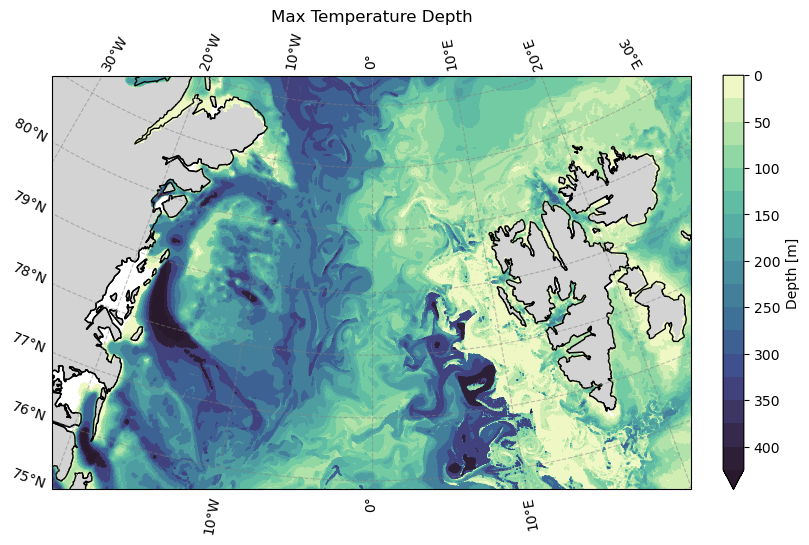

In [64]:
plot_polar_contourf(mesh, max_temp_depth*-1, levels=np.arange(0,450,25), cmap=cmo.cm.deep, extend="max", flip_cbar=True, label="Depth [m]", title="Max Temperature Depth")

Replace NaNs with -100


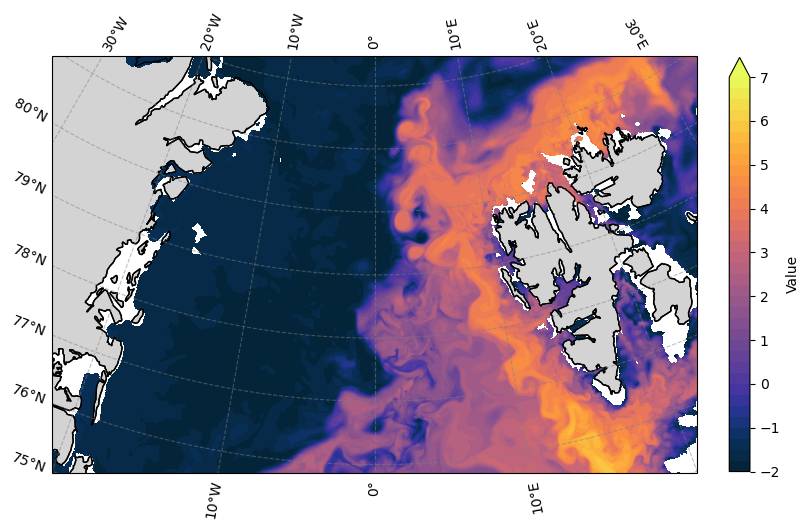

In [63]:
plot_polar_contourf(mesh, temp[:,5], levels=np.arange(-2,7.25,0.25), cmap=cmo.cm.thermal, extend="max")